# Notes 1

In [1]:
# ! pip uninstall moments -y
# If you don't have moments:
# ! pip install git+https://bitbucket.org/simongravel/moments.git

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import demes, demesdraw

# Readings

1. Gene Genealogies, Variation and Evolution (Hein et al.)
- 1.1
- 1.4
* 1.7
* 1.8
* 1.9
* 2.1.2
* 2.5.1
* You could read the rest of first two chapters too.
2. What is SFS: https://en.wikipedia.org/wiki/Allele_frequency_spectrum
3. Demographic Inference: http://evomics.org/wp-content/uploads/2016/02/160129-1-Demography.pdf

# Motivation

**What is the demographic inference in our project?**
* Population size histories
* Continous migrations -migrations- and admixtures -pulses- between populations

**What is a population size history?**
A population size history in population genetics refers to the changes in the number of individuals in a population over time. Our method uses the coalescent framework to infer the historical population size from the patterns of genetic variation in the present-day population.
- Give an example?

**What is a Continous migration -migration-?**
Continuous migration refers to a situation in which individuals are constantly moving between populations, rather than in discrete events. This can occur when populations are geographically close to each other, or when there is no clear boundary separating the populations. In this case, there is a steady flow of individuals and genetic material between the populations.
- Give an example?

**What is a Admixture -pulse-?**
a pulse migration refers to a discrete event in which a large number of individuals migrate from one population to another over a short period of time. This is in contrast to continuous migration, in which individuals are moving between populations more gradually over a longer period of time. Pulse migration events can have a significant impact on the genetic makeup of the populations involved, due to the sudden and large influx of new genetic material.
- Give an example?

In [3]:
dG = demes.load('OOAsimple.yml')

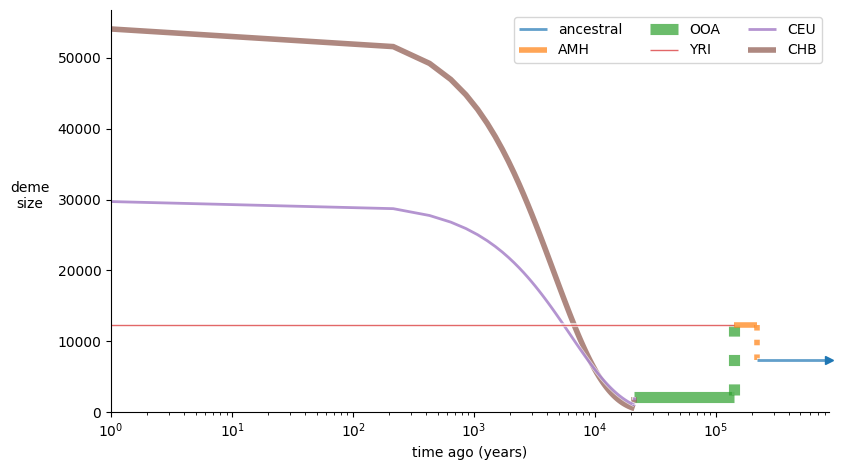

In [4]:
demesdraw.size_history(dG, log_time=True);

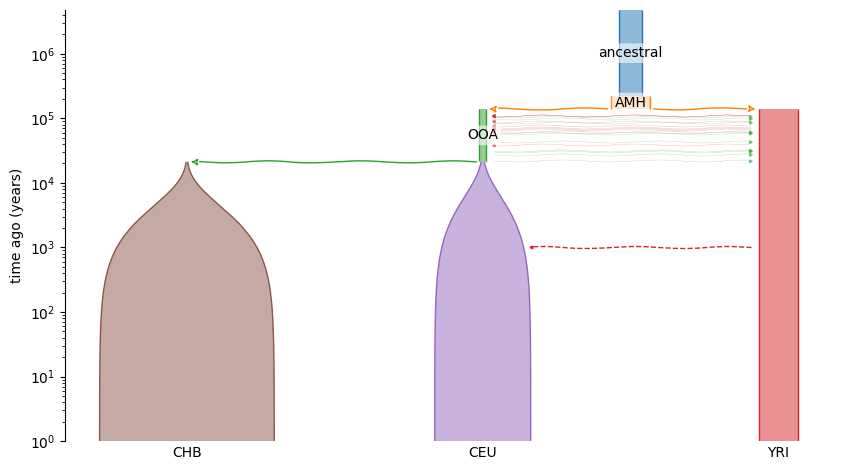

In [5]:
demesdraw.tubes(dG, log_time=True);

# Simple Coalescent

**What is Colescence Theory?**

Coalescent theory is a mathematical framework used to model the genealogical relationships between individuals in a population. It describes the process of genetic inheritance over time, and can be used to infer the **demographic history** of a population from the genetic data of its members. 

In [6]:
def coalesce(lineages):
    # Coalesces 2 lineages and returns the new lineages.
    k = len(lineages)
    i = np.random.choice(k, 2, replace = False) # randomly choose 2 lineages
    i.sort()
    i0, i1 = i
    l1 = lineages.pop(i1) # remove the lineage 1
    l0 = lineages.pop(i0) # remove the lineage 0
    new_lineage = l1+l0 # lump two lineages
    lineages.append(new_lineage) # attach the new lumped lineage
    return lineages

def mutate(lineages):
    # Mutates one of the lineages randomly
    k = len(lineages)
    i = np.random.choice(k)
    return lineages[i]

### Coalescent example

In [7]:
np.random.seed(42) # for reproducibility
lineages = [[0], [1,2], [3,4]]
coalesce(lineages)

[[3, 4], [1, 2, 0]]

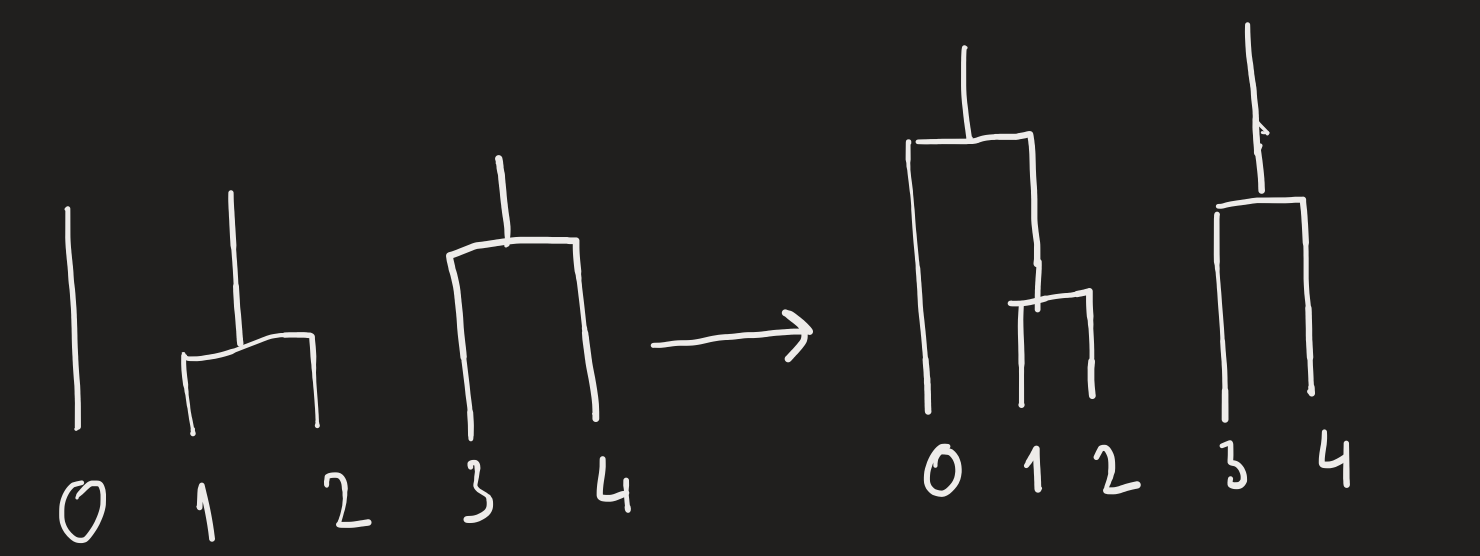

### Mutation example

In [8]:
np.random.seed(42) # for reproducibility
mutate([[0,1,2], [3,4]])

[0, 1, 2]

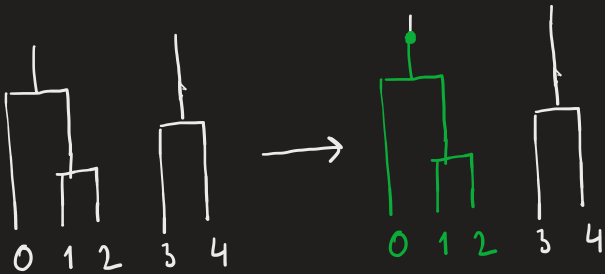

## Simulation

See Hein et al page 41 (Algorithm 2)

In [9]:
def simulate_single_pop(n, THETA):
    # Returns mutation dictionary and inter coalscent times (waiting time between coalecent events)
    # see Hein et al page 41 (Algorithm 2)
    # n: int (sample size)
    # THETA: float (mutation rate)
    
    lineages = [[i] for i in range(n)] # All lineages have their on group [[0], [1], ..., [n-1]]
    mutations = {} # Keep mutations in a dictionary
    inter_coalescent_times = [] # Waiting times for each coalescence event
    
    m = 0
    k = n
    t = 0
    while(k>1): # Step 6
        # Step 2:
        l = k*(k - 1 + THETA)/2
        t += np.random.exponential(scale=1/l)

        # Step 3:
        prob_coal = (k - 1)/(k - 1 + THETA)
        prob_mut = THETA / (k - 1 + THETA)
        u = np.random.rand()
        if u<prob_coal:
            # Step 4:
            k = k - 1
            lineages = coalesce(lineages)
            inter_coalescent_times.append(t)
            t = 0
        else:
            # Step 5:
            mutations[m] = mutate(lineages)
            m += 1
    
    return mutations, inter_coalescent_times

In [10]:
np.random.seed(108)
n = 5
THETA = 0.01

nsites = 100000 # number of independent sites

number_of_mutants = []

for _ in range(nsites):
    mutations, inter_coalescent_times = simulate_single_pop(n, THETA)
    number_of_mutations = len(mutations)
    
    if number_of_mutations == 0:
        # If there are no mutations, there are no mutants too.  
        number_of_mutants.append(0)
    elif number_of_mutations == 1:
        # Add the number of mutants 
        number_of_mutants.append(len(mutations[0]))
    else:
        # If there are more than 1 mutation we will discard this. Since it is against the infinite sites assumptions.
        pass        

In [11]:
sfs = np.bincount(number_of_mutants)
sfs = sfs/sfs.sum()
esfs = THETA/np.arange(1, n)

Text(0.5, 1.0, 'Site Frequency Spectrum')

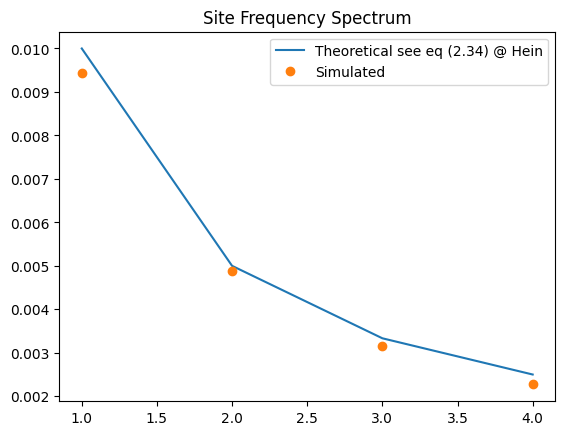

In [12]:
plt.plot(range(1, n), esfs, label = 'Theoretical see eq (2.34) @ Hein')
plt.plot(range(1, n), sfs[1:], 'o', label = 'Simulated')
plt.legend()
plt.title('Site Frequency Spectrum')

# Notes 2

# Readings:
* What is MLE?
https://machinelearningmastery.com/what-is-maximum-likelihood-estimation-in-machine-learning/ (You could use your favorite stats intro book too).

* Maximum Likelihood for the Multinomial Distribution
https://blog.jakuba.net/maximum-likelihood-for-multinomial-distribution/

* The pseudolikelihood approach (pg. 1045) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3813835/pdf/1037.pdf

## Optimization

In [13]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import moments

$$L(\pi) \propto \prod \pi_i^{x_i} $$

In [14]:
def multinomial_likelihood(Pi, X, log = True):
    # X = (x_1, x_2, ..., x_p) sum(X) = n
    # Pi = (pi_1, pi_2, ..., pi_p) sum(Pi) = 1
    if log:
        log_pi = np.log(Pi)
        # np.sum(X*log_pi)
        return X@log_pi
    else:
        return np.prod(np.power(Pi, X))  

$$\mathbf{maximize}\ L(\pi; X)\ s.t\ \sum\pi=1$$

In [15]:
Pi0 = np.array([1/2, 1/4, 1/4])
X = np.array([10, 7, 3])
multinomial_likelihood(Pi0, X)

-20.79441541679836

In [16]:
X/sum(X)

array([0.5 , 0.35, 0.15])

In [17]:
p = len(Pi0)

A = np.ones(p)
eps = 1e-10
LC = scipy.optimize.LinearConstraint(A, 1-eps, 1+eps)

In [18]:
fun = lambda Pi, X: -multinomial_likelihood(Pi, X)

In [19]:
scipy.optimize.minimize(fun=fun, args=X, constraints=LC, x0=Pi0, bounds=p*[[0, 1]])

     fun: 19.971586762390885
     jac: array([-19.99772048, -20.00256348, -20.001616  ])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.50005699, 0.34995514, 0.14998787])

$$\mathbf{maximize}\ L(\pi(\kappa); X)\ $$

In [20]:
def pi_of_kappa(kappa, p):
    r = np.arange(1, p+1)
    pi = 1/np.power(r, kappa)
    return pi/sum(pi)

In [21]:
fun = lambda kappa, X: -multinomial_likelihood(pi_of_kappa(kappa, p), X)

In [22]:
kappa0 = 1.

In [23]:
scipy.optimize.minimize(fun=fun, args=X, x0=kappa0, bounds=[[eps, np.inf]])

      fun: 20.25332111776974
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([3.55271366e-07])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 10
      nit: 3
     njev: 5
   status: 0
  success: True
        x: array([0.90748945])

Text(0.5, 0, 'kappa')

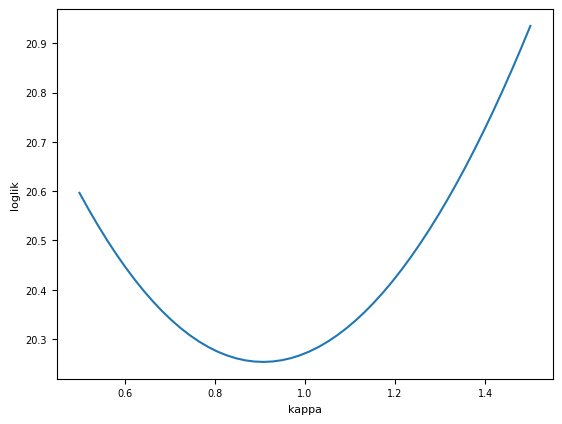

In [24]:
kappa_grid = np.linspace(0.5, 1.5)
loss = [fun(kappa, X) for kappa in kappa_grid]
plt.plot(kappa_grid, loss)
plt.ylabel('loglik')
plt.xlabel('kappa')

## Moments

In [25]:
import numpy as np
import scipy
import moments
import demes, demesdraw

In [26]:
def get_demes_model(tau, size, size_end):
    b = demes.Builder(description="demo")
    b.add_deme("A", epochs=[dict(end_time=tau,
                                 start_size=size_end),
                            dict(end_time=0,
                                 start_size = size_end,
                                 end_size = size,
                                 size_function='exponential')])
    return b.resolve()

In [27]:
g = get_demes_model(tau=1., size=10., size_end=2.)

<AxesSubplot:ylabel='time ago (generations)'>

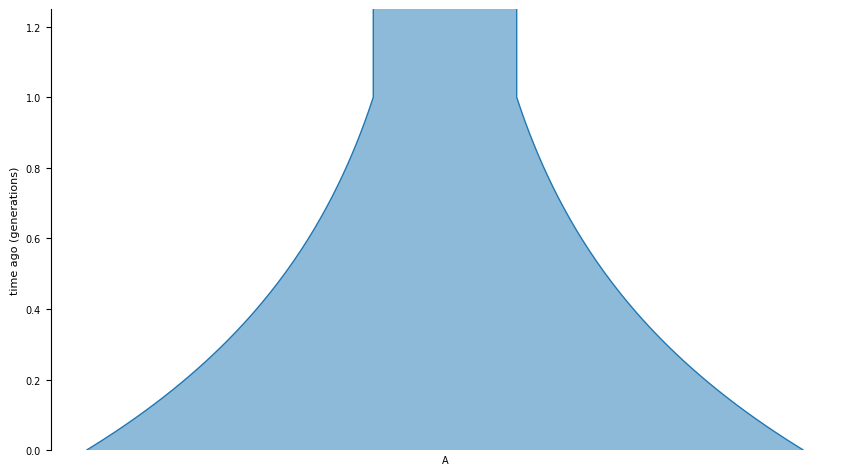

In [28]:
demesdraw.tubes(g)

In [29]:
def get_esfs_moments(g, sample_size):
    esfs = moments.Spectrum.from_demes(g, sampled_demes=['A'], sample_sizes=[sample_size])
    return np.array(esfs)[1:-1]

In [30]:
Z = get_esfs_moments(g, 10)
pi = Z/Z.sum()
pi

array([0.4427525 , 0.1622256 , 0.10063403, 0.0741946 , 0.05911113,
       0.0492115 , 0.04217231, 0.03689923, 0.03279909])

### Task: Build a Maximum Likelihood method to learn tau, size and size_end parameters.

In [31]:
from tqdm.notebook import trange

In [32]:
eps = 1e-8

In [33]:
sfs = np.array([10, 4, 5, 3, 1, 0, 1, 0, 0]) # in previous example X

In [34]:
def pi_of_demo_params(demo_params, sample_size):
    tau, size, size_end = demo_params
    g = get_demes_model(tau, size, size_end)
    
    esfs = get_esfs_moments(g, sample_size)
    return esfs/esfs.sum()

In [35]:
tau = 1.
size = 10.
size_end = 2.


demo_params = (tau, size, size_end)
sample_size = len(sfs) + 1

pi_of_demo_params(demo_params, sample_size)

array([0.4427525 , 0.1622256 , 0.10063403, 0.0741946 , 0.05911113,
       0.0492115 , 0.04217231, 0.03689923, 0.03279909])

In [36]:
fun = lambda demo_params, sfs: -multinomial_likelihood(pi_of_demo_params(demo_params, len(sfs) + 1), sfs)

In [ ]:
x = demo_params
ret = scipy.optimize.minimize(
        fun=fun, 
        args=sfs, 
        x0=x, 
        bounds=3 * [[eps, np.inf]],
        options={"maxiter": 250}
    )

In [37]:
loss = []
niter = 250

x = demo_params

for _ in trange(niter):
    ret = scipy.optimize.minimize(
        fun=fun, 
        args=sfs, 
        x0=x, 
        bounds=3 * [[eps, np.inf]],
        options={"maxiter": 1}
    )
    
    x = ret.x
    
    loss.append(ret.fun)

  0%|          | 0/250 [00:00<?, ?it/s]

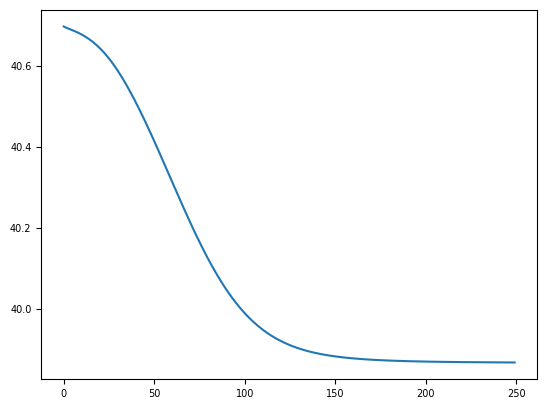

In [38]:
plt.plot(loss)

In [39]:
fun(ret.x, sfs)

39.86747744312431

In [ ]:
ret

In [40]:
ret.x

array([9.52394485, 3.86467962, 0.44072817])

<AxesSubplot:ylabel='time ago (generations)'>

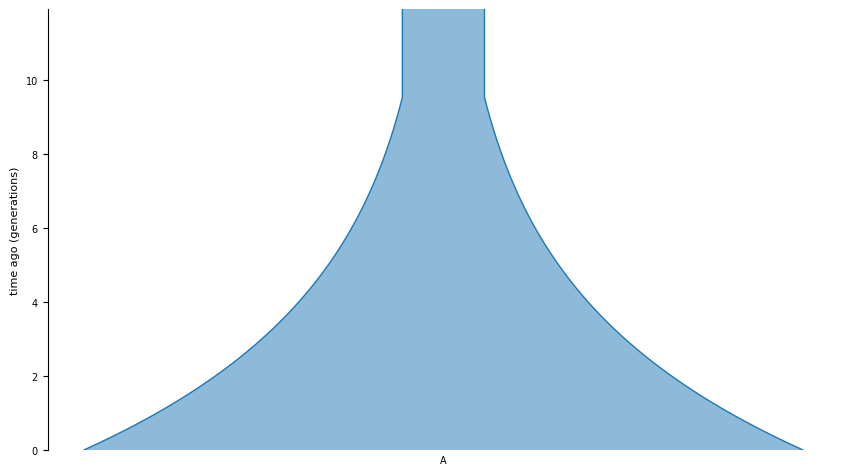

In [41]:
g = get_demes_model(*ret.x)
demesdraw.tubes(g)

In [42]:
# sensitivity analysis
# profile likelihood
# compare intervals